CNN 1D 모델 여러 개를 학습시킨후 Stacking 기법을 이용해 앙상블 했습니다.    
성능을 높이기 위해 파생 변수를 추가하고 StandardScaler를 사용해 데이터 스케일링을 진행했습니다.  
자세한 설명과 참고한 사이트들은 아래 코드들과 함께 추가했습니다


## 로드 

In [ ]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True) 

import pandas as pd 
import numpy as np 
import tensorflow as tf 
from tensorflow.keras import utils
from tensorflow.keras.layers import Flatten, MaxPooling1D, Input, concatenate, Conv1D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D, Dropout, Dense, Reshape, LSTM, SpatialDropout1D, AveragePooling1D
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

from keras.callbacks import ModelCheckpoint
import os
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

Mounted at /content/drive


In [ ]:
train_features = pd.read_csv("/content/drive/MyDrive/ML/dacon/exercise_action/train_features.csv")
train_labels = pd.read_csv("/content/drive/MyDrive/ML/dacon/exercise_action/train_labels.csv")
test_features = pd.read_csv('/content/drive/MyDrive/ML/dacon/exercise_action/test_features.csv')
sample_sub = pd.read_csv('/content/drive/MyDrive/ML/dacon/exercise_action/sample_submission.csv')

train_features.head()

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234


## Feature  
주어진 피처만으로는 만족할만한 성능을 내지 못해, 데이터를 대변할 수 있을만한 피처를 추가적으로 생성할 수 있을까 고민하다가 아래와 같은 파생변수를 추가했습니다.  
- 가속도와 자이로스코프 제곱합 'acc_t' 와 'gy_t'
- 자이로스코프의 경우 이전 time에서 얼마나 달라졌는지를 나타내는 'gy_x_diff' 등


In [ ]:
feature_names = ['acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z', 'acc_t', 'gy_t', 'gy_x_diff', 'gy_y_diff', 'gy_z_diff']

In [ ]:
# 가속도와 자이로스코프 제곱합

train_features['acc_t']  = (train_features['acc_x']**2+train_features['acc_y']**2+train_features['acc_z']**2)**(1/2)
test_features['acc_t']  = (test_features['acc_x']**2+test_features['acc_y']**2+test_features['acc_z']**2)**(1/2)
train_features['gy_t']  = (train_features['gy_x']**2+train_features['gy_y']**2+train_features['gy_z']**2)**(1/2)
test_features['gy_t']  = (test_features['gy_x']**2+test_features['gy_y']**2+test_features['gy_z']**2)**(1/2)

In [ ]:
# 자이로스코프 변화량

train_features['gy_x_diff'] = 0
train_features['gy_y_diff'] = 0
train_features['gy_z_diff'] = 0

In [ ]:
train_df = train_features.iloc[:, 2:]

In [ ]:
train_df = train_df.to_numpy()
train_df = train_df.reshape(3125, 600, 11)
train_df.shape

(3125, 600, 11)

In [ ]:
for i in range (3125):
    for j in range(600):
        if j != 0:
            train_df[i][j][8] = train_df[i][j][3] - train_df[i][j-1][3]
            train_df[i][j][9] = train_df[i][j][4] - train_df[i][j-1][4]
            train_df[i][j][10] = train_df[i][j][5] - train_df[i][j-1][5] 
        if j == 0:
            train_df[i][j][8] = train_df[i][j][3]
            train_df[i][j][9] = train_df[i][j][4]
            train_df[i][j][10] = train_df[i][j][5]

In [ ]:
pd.DataFrame(train_df.reshape(1875000,11), columns=feature_names)

,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_t,gy_t,gy_x_diff,gy_y_diff,gy_z_diff
0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112,1.228355,44.010999,-0.591608,-30.549010,-31.676112
1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216,1.315689,46.403958,0.894708,-8.590094,6.748896
2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629,1.343234,50.851423,-3.920378,-4.983461,-0.092413
3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013,1.330969,60.281107,6.330264,-9.475278,-2.434384
4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234,1.333070,64.446693,1.573721,-4.308718,-0.507222
...,...,...,...,...,...,...,...,...,...,...,...
1874995,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437,1.013606,132.293402,-3.012893,-0.692606,-0.167602
1874996,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087,1.004243,130.931134,-0.781232,2.216855,-0.334650
1874997,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125,1.009373,129.739912,2.275994,3.020737,-2.740038
1874998,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478,1.001557,129.726288,4.236545,-0.363423,-0.894353


In [ ]:
test_features['gy_x_diff'] = 0
test_features['gy_y_diff'] = 0
test_features['gy_z_diff'] = 0

In [ ]:
test_df = test_features.iloc[:, 2:].to_numpy()
test_df = test_df.reshape(782, 600, 11)
test_df.shape

(782, 600, 11)

In [ ]:
for i in range (782):
    for j in range(600):
        if j != 0:
            test_df[i][j][8] = test_df[i][j][3] - test_df[i][j-1][3]
            test_df[i][j][9] = test_df[i][j][4] - test_df[i][j-1][4]
            test_df[i][j][10] = test_df[i][j][5] - test_df[i][j-1][5] 
        if j == 0:
            test_df[i][j][8] = test_df[i][j][3]
            test_df[i][j][9] = test_df[i][j][4]
            test_df[i][j][10] = test_df[i][j][5]

In [ ]:
pd.DataFrame(test_df.reshape(469200,11), columns=feature_names)

,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_t,gy_t,gy_x_diff,gy_y_diff,gy_z_diff
0,-0.628100,-0.160155,0.151487,49.665357,88.435961,13.597668,0.665663,102.335055,49.665357,88.435961,13.597668
1,-0.462548,0.012462,-0.053726,56.953059,96.185341,16.278458,0.465824,112.961317,7.287703,7.749380,2.680790
2,-0.363481,-0.091789,-0.130004,29.557396,93.836453,13.329043,0.396793,99.280325,-27.395664,-2.348888,-2.949415
3,-0.351750,-0.239870,-0.193053,23.686172,88.608721,13.449771,0.467477,92.700790,-5.871224,-5.227732,0.120728
4,-0.312934,-0.123762,-0.318621,20.410071,85.327707,13.884912,0.463426,88.826681,-3.276102,-3.281014,0.435141
...,...,...,...,...,...,...,...,...,...,...,...
469195,0.104191,-0.784979,0.639513,-10.475346,14.095361,-190.358982,1.017853,191.167346,-15.429983,-16.990549,-0.173423
469196,0.103297,-0.758954,0.615687,-25.360272,-8.523018,-180.393291,0.982726,182.366457,-14.884926,-22.618380,9.965691
469197,0.128294,-0.749389,0.586184,-27.917723,-23.186245,-162.624160,0.960028,166.624184,-2.557451,-14.663227,17.769131
469198,0.104130,-0.692731,0.573397,-27.847980,-30.407555,-138.761676,0.905265,144.758185,0.069743,-7.221309,23.862484


## 데이터 스케일링  
Feature가 가지는 범위의 영향을 줄이기 위해 feature 값들이 표준정규분포를 따르도록 변환하는 StandardScaler를 사용했습니다  
아래 사이트를 참고했습니다  
https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/ 

feature의 분포 보여주는 그래프

In [ ]:
from matplotlib import pyplot
%matplotlib inline

def plot_variable_distributions(train_x):
	Longtrain_x = train_x.reshape((train_x.shape[0] * train_x.shape[1], train_x.shape[2]))
	pyplot.figure()
	xaxis = None
	for i in range(Longtrain_x.shape[1]):
		ax = pyplot.subplot(Longtrain_x.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-100, 100)
		if i == 0:
			xaxis = ax
		pyplot.hist(Longtrain_x[:, i], bins=100)
	pyplot.show()

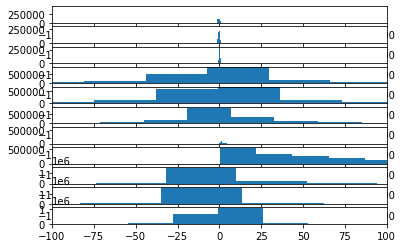

In [ ]:
plot_variable_distributions(train_df)

standard scaler 사용

In [ ]:
from sklearn.preprocessing import StandardScaler

def standardize(train_x, test_x):
  Longtrain_x = train_x.reshape((train_x.shape[0] * train_x.shape[1], train_x.shape[2]))
  Longtest_x = test_x.reshape((test_x.shape[0] * test_x.shape[1], test_x.shape[2]))

  scaler=StandardScaler()
  scaler.fit(Longtrain_x)
  Flattrain_x=scaler.transform(Longtrain_x)
  Flattest_x=scaler.transform(Longtest_x)

  train_scaled=pd.DataFrame(data=Flattrain_x, columns=feature_names)
  print('scaling 후 feature 평균')
  print(train_scaled.mean())
  print('\nscaling 후 feature 분산')
  print(train_scaled.var())

  return Flattrain_x, Flattest_x

In [ ]:
train_st, test_st = standardize(train_df, test_df)

scaling 후 feature 평균
acc_x       -1.887813e-16
acc_y       -7.211565e-17
acc_z        8.873347e-17
gy_x        -1.875889e-17
gy_y        -2.319081e-17
gy_z        -6.808657e-17
acc_t       -2.351409e-15
gy_t         8.602732e-16
gy_x_diff   -7.936925e-18
gy_y_diff    1.427802e-18
gy_z_diff    1.420232e-18
dtype: float64

scaling 후 feature 분산
acc_x        1.000001
acc_y        1.000001
acc_z        1.000001
gy_x         1.000001
gy_y         1.000001
gy_z         1.000001
acc_t        1.000001
gy_t         1.000001
gy_x_diff    1.000001
gy_y_diff    1.000001
gy_z_diff    1.000001
dtype: float64


In [ ]:
train_st = pd.DataFrame(data=train_st, columns=feature_names)
train_st

,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_t,gy_t,gy_x_diff,gy_y_diff,gy_z_diff
0,2.307314,-0.029939,-0.432104,0.011776,-0.410859,-0.461007,0.386070,-0.348596,-0.021179,-1.232656,-1.742028
1,2.421086,-0.063321,-0.504058,0.026484,-0.528052,-0.365459,0.606254,-0.322359,0.032358,-0.346531,0.370951
2,2.444664,-0.056749,-0.654199,-0.037962,-0.596041,-0.366767,0.675697,-0.273597,-0.141080,-0.200989,-0.005251
3,2.428612,-0.116782,-0.573407,0.066099,-0.725311,-0.401232,0.644776,-0.170208,0.228144,-0.382251,-0.134035
4,2.439475,-0.044220,-0.588886,0.091969,-0.784094,-0.408413,0.650073,-0.124536,0.056815,-0.173761,-0.028061
...,...,...,...,...,...,...,...,...,...,...,...
1874995,-0.367432,-0.845648,0.503707,-0.461266,-1.413128,-1.092639,-0.155342,0.619348,-0.108393,-0.027837,-0.009385
1874996,-0.326315,-0.845833,0.578875,-0.474109,-1.382884,-1.097377,-0.178947,0.604411,-0.028009,0.089570,-0.018571
1874997,-0.300794,-0.859728,0.652722,-0.436694,-1.341672,-1.136169,-0.166013,0.591351,0.082111,0.122010,-0.150843
1874998,-0.253120,-0.886873,0.673002,-0.367051,-1.346630,-1.148831,-0.185719,0.591201,0.152729,-0.014553,-0.049349


In [ ]:
test_st = pd.DataFrame(data=test_st, columns=feature_names)
test_st

,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_t,gy_t,gy_x_diff,gy_y_diff,gy_z_diff
0,-0.249727,0.002786,0.202699,0.837933,1.212439,0.179961,-1.032556,0.290879,1.789056,3.568837,0.747563
1,-0.018931,0.296752,-0.231628,0.957733,1.318163,0.217914,-1.536379,0.407387,0.262631,0.312829,0.147247
2,0.119178,0.119214,-0.393070,0.507385,1.286118,0.176158,-1.710416,0.257386,-0.986650,-0.094674,-0.162356
3,0.135533,-0.132967,-0.526513,0.410870,1.214796,0.177867,-1.532211,0.185247,-0.211349,-0.210847,0.006470
4,0.189646,0.064763,-0.792275,0.357015,1.170034,0.184028,-1.542424,0.142771,-0.117873,-0.132289,0.023759
...,...,...,...,...,...,...,...,...,...,...,...
469195,0.771160,-1.061284,1.235599,-0.150699,0.198219,-2.707576,-0.144635,1.264852,-0.555651,-0.685521,-0.009705
469196,0.769913,-1.016963,1.185170,-0.395387,-0.110361,-2.566486,-0.233194,1.168357,-0.536018,-0.912625,0.547841
469197,0.804762,-1.000674,1.122728,-0.437428,-0.310409,-2.314917,-0.290419,0.995756,-0.091988,-0.591605,0.976950
469198,0.771076,-0.904187,1.095665,-0.436282,-0.408929,-1.977082,-0.428486,0.756014,0.002643,-0.291295,1.312021


# 데이터 전처리

In [ ]:
# convert features into 3d [num_id, num_time, num_features] => train
train_x = train_st.to_numpy()
train_x = train_x.reshape(3125, 600, 11)
train_x.shape

(3125, 600, 11)

In [ ]:
# convert features into 3d => test
test_x = test_st.to_numpy()
test_x = test_x.reshape(782, 600, 11)
test_x.shape

(782, 600, 11)

In [ ]:
# one hot encoding 
train_y = train_labels["label"]
train_y = np.array(train_y)
from tensorflow.keras.utils import to_categorical
train_y = to_categorical(train_y)
train_y.shape

(3125, 61)

In [ ]:
num_classes = 61
num_id = train_x.shape[0]
num_time = train_x.shape[1]
num_features = train_x.shape[2]

## Model  
cnn 모델을 여러 개 만들어 앙상블했습니다.

LSTM이나 GRU 층을 끼고도 만들어보았지만, 성능 향상에 도움이 되지 않아 Conv1D 층을 중심으로 만들었습니다.

데이터 수가 부족하다고 판단해 validation data 없이 모델을 학습시켰습니다. (fit시킬 때 validation_split=0)

   

In [ ]:
def acc_loss_plot(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc = 'upper left')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')

    plt.show()

### 1. model1 

In [ ]:
def build_model1(filter, l_rate, opti):

    ip = Input(shape=(num_time, num_features))

    y = Conv1D(64, 11, activation='relu')(ip)
    y = BatchNormalization()(y)
    y = MaxPooling1D()(y)

    y = Conv1D(64, 5, activation='relu')(y)
    y = BatchNormalization()(y)
    y = MaxPooling1D()(y)
    y = SpatialDropout1D(0.3)(y)

    y = GlobalAveragePooling1D()(y)
    out = Dense(num_classes, activation='softmax')(y)

    model1 = Model(ip, out)

    if opti == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=l_rate)
    if opti == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=l_rate)

    model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model1.summary()

    return model1

In [ ]:
model1 = build_model1(64, 0.0005, 'adam')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 600, 11)]         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 590, 64)           7808      
_________________________________________________________________
batch_normalization_2 (Batch (None, 590, 64)           256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 295, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 291, 64)           20544     
_________________________________________________________________
batch_normalization_3 (Batch (None, 291, 64)           256       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 145, 64)           0   

In [ ]:
from keras.callbacks import ModelCheckpoint
import os

checkpoint_path_1 = "training_model_1/cp.ckpt"
checkpoint_dir_1 = os.path.dirname(checkpoint_path_1)
cp_callback_1 = ModelCheckpoint(filepath=checkpoint_path_1, monitor='loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=30, mode='min')
hist1 = model1.fit(train_x,train_y, epochs=250, batch_size=128, validation_split=0, callbacks=[early_stopping, cp_callback_1])

Epoch 1/250
25/25 [==============================] - 1s 20ms/step - loss: 3.9271 - accuracy: 0.1908

Epoch 00001: loss improved from inf to 3.63656, saving model to training_model_1/cp.ckpt
Epoch 2/250
25/25 [==============================] - 0s 19ms/step - loss: 3.0174 - accuracy: 0.4446

Epoch 00002: loss improved from 3.63656 to 2.85687, saving model to training_model_1/cp.ckpt
Epoch 3/250
25/25 [==============================] - 0s 19ms/step - loss: 2.5139 - accuracy: 0.5188

Epoch 00003: loss improved from 2.85687 to 2.47932, saving model to training_model_1/cp.ckpt
Epoch 4/250
25/25 [==============================] - 0s 18ms/step - loss: 2.2886 - accuracy: 0.5332

Epoch 00004: loss improved from 2.47932 to 2.23221, saving model to training_model_1/cp.ckpt
Epoch 5/250
25/25 [==============================] - 0s 18ms/step - loss: 2.0826 - accuracy: 0.5776

Epoch 00005: loss improved from 2.23221 to 2.05881, saving model to training_model_1/cp.ckpt
Epoch 6/250
25/25 [===============

In [ ]:
model1.save('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_11.h5')

###2. model2


In [ ]:
tf.keras.backend.clear_session()

def build_model2(l_rate, opti):

    ip = Input(shape=(num_time, num_features))

    y = Conv1D(64, 8, padding='same', activation="relu")(ip)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)

    y = Conv1D(64, 5, padding='same', activation="relu")(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)
    
    y = Conv1D(64, 3, padding='same', activation="relu")(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.4)(y)

    y = GlobalAveragePooling1D()(y)
    y = Flatten()(y)
    out = Dense(num_classes, activation='softmax')(y)

    model2 = Model(ip, out)
    model2.summary()

    # add load model code here to fine-tune

    if opti == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=l_rate)
    if opti == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=l_rate)

    model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model2


model2 = build_model2(0.0005, 'adam')
    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 11)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 600, 64)           5696      
_________________________________________________________________
batch_normalization (BatchNo (None, 600, 64)           256       
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 600, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 600, 64)           20544     
_________________________________________________________________
batch_normalization_1 (Batch (None, 600, 64)           256       
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 600, 64)           0     

In [ ]:
from keras.callbacks import ModelCheckpoint
import os

checkpoint_path_1 = "training_model_1/cp.ckpt"
checkpoint_dir_1 = os.path.dirname(checkpoint_path_1)
cp_callback_1 = ModelCheckpoint(filepath=checkpoint_path_1, monitor='loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=30, mode='min')
hist2 = model2.fit(train_x,train_y, epochs=300, batch_size=128, validation_split=0, callbacks=[early_stopping, cp_callback_1])

Epoch 1/300
25/25 [==============================] - 2s 35ms/step - loss: 4.0691 - accuracy: 0.1185

Epoch 00001: loss improved from inf to 3.88692, saving model to training_model_1/cp.ckpt
Epoch 2/300
25/25 [==============================] - 1s 34ms/step - loss: 3.3968 - accuracy: 0.3804

Epoch 00002: loss improved from 3.88692 to 3.31811, saving model to training_model_1/cp.ckpt
Epoch 3/300
25/25 [==============================] - 1s 35ms/step - loss: 3.0214 - accuracy: 0.4501

Epoch 00003: loss improved from 3.31811 to 2.96711, saving model to training_model_1/cp.ckpt
Epoch 4/300
25/25 [==============================] - 1s 35ms/step - loss: 2.7263 - accuracy: 0.4896

Epoch 00004: loss improved from 2.96711 to 2.72559, saving model to training_model_1/cp.ckpt
Epoch 5/300
25/25 [==============================] - 1s 34ms/step - loss: 2.5616 - accuracy: 0.5058

Epoch 00005: loss improved from 2.72559 to 2.52922, saving model to training_model_1/cp.ckpt
Epoch 6/300
25/25 [===============

In [ ]:
model2.save('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_22.h5')

###3. model3


In [ ]:
tf.keras.backend.clear_session()

def build_model3(filter, l_rate, opti):

    ip = Input(shape=(num_time, num_features))

    y = Conv1D(filter, 11, padding='same', activation='relu')(ip)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.3)(y)

    y = Conv1D(filter, 5, padding='same', activation='relu')(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.3)(y)

    y = Conv1D(filter, 3, padding='same', activation='relu')(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.3)(y)
    
    y = GlobalAveragePooling1D()(y)
    y = Flatten()(y)
    out = Dense(num_classes, activation='softmax')(y)

    model3 = Model(ip, out)

    if opti == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=l_rate)
    if opti == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=l_rate)

    model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model3.summary()

    return model3

In [ ]:
model3 = build_model3(64, 0.001, 'adam')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 11)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 600, 64)           7808      
_________________________________________________________________
batch_normalization (BatchNo (None, 600, 64)           256       
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 600, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 600, 64)           20544     
_________________________________________________________________
batch_normalization_1 (Batch (None, 600, 64)           256       
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 600, 64)           0     

In [ ]:
from keras.callbacks import ModelCheckpoint
import os

checkpoint_path_1 = "training_model_1/cp.ckpt"
checkpoint_dir_1 = os.path.dirname(checkpoint_path_1)
cp_callback_1 = ModelCheckpoint(filepath=checkpoint_path_1, monitor='loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=30, mode='min')
hist3 = model3.fit(train_x,train_y, epochs=200, batch_size=128, validation_split=0, callbacks=[early_stopping, cp_callback_1])

Epoch 1/200
25/25 [==============================] - 2s 37ms/step - loss: 3.9209 - accuracy: 0.1761

Epoch 00001: loss improved from inf to 3.65238, saving model to training_model_1/cp.ckpt
Epoch 2/200
25/25 [==============================] - 1s 35ms/step - loss: 2.9823 - accuracy: 0.4495

Epoch 00002: loss improved from 3.65238 to 2.92870, saving model to training_model_1/cp.ckpt
Epoch 3/200
25/25 [==============================] - 1s 34ms/step - loss: 2.5850 - accuracy: 0.4821

Epoch 00003: loss improved from 2.92870 to 2.51626, saving model to training_model_1/cp.ckpt
Epoch 4/200
25/25 [==============================] - 1s 35ms/step - loss: 2.3402 - accuracy: 0.5147

Epoch 00004: loss improved from 2.51626 to 2.28737, saving model to training_model_1/cp.ckpt
Epoch 5/200
25/25 [==============================] - 1s 34ms/step - loss: 2.1055 - accuracy: 0.5478

Epoch 00005: loss improved from 2.28737 to 2.11303, saving model to training_model_1/cp.ckpt
Epoch 6/200
25/25 [===============

In [ ]:
model3.save('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_33.h5')

###4. model4


In [ ]:
tf.keras.backend.clear_session()

def build_model4(l_rate, opti):

    ip = Input(shape=(num_time, num_features))

    y = Conv1D(64, 8, padding='same', activation="relu")(ip)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)

    y = Conv1D(64, 5, padding='same', activation="relu")(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)

    y = Conv1D(64, 3, padding='same', activation="relu")(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)

    y = GlobalAveragePooling1D()(y)
    y = Flatten()(y)
    out = Dense(num_classes, activation='softmax')(y)

    model4 = Model(ip, out)
    model4.summary()

    if opti == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=l_rate)
    if opti == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=l_rate)

    model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model4


model4 = build_model4(0.0005, 'adam')


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 11)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 600, 64)           5696      
_________________________________________________________________
batch_normalization (BatchNo (None, 600, 64)           256       
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 600, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 600, 64)           20544     
_________________________________________________________________
batch_normalization_1 (Batch (None, 600, 64)           256       
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 600, 64)           0     

In [ ]:
from keras.callbacks import ModelCheckpoint
import os

checkpoint_path_1 = "training_model_1/cp.ckpt"
checkpoint_dir_1 = os.path.dirname(checkpoint_path_1)
cp_callback_1 = ModelCheckpoint(filepath=checkpoint_path_1, monitor='loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=30, mode='min')
hist4 = model4.fit(train_x,train_y, epochs=300, batch_size=128, validation_split=0, callbacks=[early_stopping, cp_callback_1])

Epoch 1/300
25/25 [==============================] - 2s 35ms/step - loss: 3.9975 - accuracy: 0.1430

Epoch 00001: loss improved from inf to 3.82887, saving model to training_model_1/cp.ckpt
Epoch 2/300
25/25 [==============================] - 1s 34ms/step - loss: 3.3249 - accuracy: 0.3965

Epoch 00002: loss improved from 3.82887 to 3.22416, saving model to training_model_1/cp.ckpt
Epoch 3/300
25/25 [==============================] - 1s 34ms/step - loss: 2.9003 - accuracy: 0.4683

Epoch 00003: loss improved from 3.22416 to 2.84994, saving model to training_model_1/cp.ckpt
Epoch 4/300
25/25 [==============================] - 1s 34ms/step - loss: 2.6812 - accuracy: 0.4850

Epoch 00004: loss improved from 2.84994 to 2.62207, saving model to training_model_1/cp.ckpt
Epoch 5/300
25/25 [==============================] - 1s 34ms/step - loss: 2.4672 - accuracy: 0.5077

Epoch 00005: loss improved from 2.62207 to 2.45215, saving model to training_model_1/cp.ckpt
Epoch 6/300
25/25 [===============

In [ ]:
model4.save('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_44.h5')

###5. model5



In [ ]:
tf.keras.backend.clear_session()

def build_model5(l_rate, opti):

    ip = Input(shape=(num_time, num_features))

    y = Conv1D(64, 11, padding='same', activation="relu")(ip)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)
    
    y = Conv1D(64, 5, padding='same', activation="relu")(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)

    y = Conv1D(64, 3, padding='same', activation="relu")(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)

    y = Conv1D(128, 11, padding='same', activation="relu")(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)

    y = Conv1D(128, 5, padding='same', activation="relu")(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)

    y = Conv1D(128, 3, padding='same', activation="relu")(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)

    y = GlobalAveragePooling1D()(y)
    out = Dense(num_classes, activation='softmax')(y)

    model4 = Model(ip, out)
    model4.summary()

    if opti == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=l_rate)
    if opti == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=l_rate)

    model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model4


model5 = build_model5(0.0005, 'adam')


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 11)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 600, 64)           7808      
_________________________________________________________________
batch_normalization (BatchNo (None, 600, 64)           256       
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 600, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 600, 64)           20544     
_________________________________________________________________
batch_normalization_1 (Batch (None, 600, 64)           256       
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 600, 64)           0     

In [ ]:
from keras.callbacks import ModelCheckpoint
import os

checkpoint_path_1 = "training_model_1/cp.ckpt"
checkpoint_dir_1 = os.path.dirname(checkpoint_path_1)
cp_callback_1 = ModelCheckpoint(filepath=checkpoint_path_1, monitor='loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=30, mode='min')
hist5 = model5.fit(train_x,train_y, epochs=200, batch_size=128, validation_split=0, callbacks=[early_stopping, cp_callback_1])

Epoch 1/200
25/25 [==============================] - 5s 111ms/step - loss: 3.7740 - accuracy: 0.2295

Epoch 00001: loss improved from inf to 3.46290, saving model to training_model_1/cp.ckpt
Epoch 2/200
25/25 [==============================] - 3s 107ms/step - loss: 2.7604 - accuracy: 0.4621

Epoch 00002: loss improved from 3.46290 to 2.69740, saving model to training_model_1/cp.ckpt
Epoch 3/200
25/25 [==============================] - 3s 108ms/step - loss: 2.4575 - accuracy: 0.5056

Epoch 00003: loss improved from 2.69740 to 2.37818, saving model to training_model_1/cp.ckpt
Epoch 4/200
25/25 [==============================] - 3s 107ms/step - loss: 2.2228 - accuracy: 0.5257

Epoch 00004: loss improved from 2.37818 to 2.17345, saving model to training_model_1/cp.ckpt
Epoch 5/200
25/25 [==============================] - 3s 107ms/step - loss: 2.0444 - accuracy: 0.5397

Epoch 00005: loss improved from 2.17345 to 2.01730, saving model to training_model_1/cp.ckpt
Epoch 6/200
25/25 [==========

In [ ]:
model5.save('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_55.h5')

###6. model6


In [ ]:
tf.keras.backend.clear_session()

def build_model6(l_rate, opti):

    ip = Input(shape=(num_time, num_features))

    y = Conv1D(64, 8, padding='same', activation="relu")(ip)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)

    y = Conv1D(64, 5, padding='same', activation="relu")(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)

    y = Conv1D(64, 3, padding='same', activation="relu")(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)

    y = Conv1D(128, 8, padding='same', activation="relu")(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)

    y = Conv1D(128, 5, padding='same', activation="relu")(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)

    y = Conv1D(128, 3, padding='same', activation="relu")(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)

    y = Conv1D(128, 8, padding='same', activation="relu")(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)

    y = Conv1D(128, 5, padding='same', activation="relu")(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)
    
    y = Conv1D(128, 3, padding='same', activation="relu")(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)

    y = GlobalAveragePooling1D()(y)
    out = Dense(num_classes, activation='softmax')(y)

    model4 = Model(ip, out)
    model4.summary()

    if opti == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=l_rate)
    if opti == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=l_rate)

    model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model4


model6 = build_model6(0.0005, 'adam')


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 11)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 600, 64)           5696      
_________________________________________________________________
batch_normalization (BatchNo (None, 600, 64)           256       
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 600, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 600, 64)           20544     
_________________________________________________________________
batch_normalization_1 (Batch (None, 600, 64)           256       
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 600, 64)           0     

In [ ]:
from keras.callbacks import ModelCheckpoint
import os

checkpoint_path_1 = "training_model_1/cp.ckpt"
checkpoint_dir_1 = os.path.dirname(checkpoint_path_1)
cp_callback_1 = ModelCheckpoint(filepath=checkpoint_path_1, monitor='loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=30, mode='min')
hist6 = model6.fit(train_x,train_y, epochs=200, batch_size=128, validation_split=0, callbacks=[early_stopping, cp_callback_1])

Epoch 1/200
25/25 [==============================] - 7s 190ms/step - loss: 4.0072 - accuracy: 0.1305

Epoch 00001: loss improved from inf to 3.72702, saving model to training_model_1/cp.ckpt
Epoch 2/200
25/25 [==============================] - 5s 187ms/step - loss: 2.9993 - accuracy: 0.4412

Epoch 00002: loss improved from 3.72702 to 2.94746, saving model to training_model_1/cp.ckpt
Epoch 3/200
25/25 [==============================] - 5s 187ms/step - loss: 2.6563 - accuracy: 0.4822

Epoch 00003: loss improved from 2.94746 to 2.59068, saving model to training_model_1/cp.ckpt
Epoch 4/200
25/25 [==============================] - 5s 187ms/step - loss: 2.3608 - accuracy: 0.5033

Epoch 00004: loss improved from 2.59068 to 2.35784, saving model to training_model_1/cp.ckpt
Epoch 5/200
25/25 [==============================] - 5s 186ms/step - loss: 2.1811 - accuracy: 0.5355

Epoch 00005: loss improved from 2.35784 to 2.17467, saving model to training_model_1/cp.ckpt
Epoch 6/200
25/25 [==========

In [ ]:
model6.save('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_66.h5')

###8. model8


In [ ]:
tf.keras.backend.clear_session()

def build_model8(l_rate, opti):

    ip = Input(shape=(num_time, num_features))

    y = Conv1D(64, 9, padding='same', activation="relu")(ip)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.3)(y)

    y = Conv1D(64, 5, padding='same', activation="relu")(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.4)(y)

    y = Conv1D(64, 3, padding='same', activation="relu")(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.5)(y)

    y = GlobalAveragePooling1D()(y)
    y = Flatten()(y)
    out = Dense(num_classes, activation='softmax')(y)

    model4 = Model(ip, out)
    model4.summary()

    if opti == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=l_rate)
    if opti == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=l_rate)

    model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model4


model8 = build_model8(0.0005, 'adam')


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 11)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 600, 64)           6400      
_________________________________________________________________
batch_normalization (BatchNo (None, 600, 64)           256       
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 600, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 600, 64)           20544     
_________________________________________________________________
batch_normalization_1 (Batch (None, 600, 64)           256       
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 600, 64)           0     

In [ ]:
from keras.callbacks import ModelCheckpoint
import os

checkpoint_path_1 = "training_model_1/cp.ckpt"
checkpoint_dir_1 = os.path.dirname(checkpoint_path_1)
cp_callback_1 = ModelCheckpoint(filepath=checkpoint_path_1, monitor='loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=30, mode='min')
hist8 = model8.fit(train_x,train_y, epochs=400, batch_size=128, validation_split=0, callbacks=[early_stopping, cp_callback_1])

Epoch 1/400
25/25 [==============================] - 2s 36ms/step - loss: 4.2900 - accuracy: 0.0441

Epoch 00001: loss improved from inf to 4.16641, saving model to training_model_1/cp.ckpt
Epoch 2/400
25/25 [==============================] - 1s 34ms/step - loss: 3.7135 - accuracy: 0.2746

Epoch 00002: loss improved from 4.16641 to 3.63879, saving model to training_model_1/cp.ckpt
Epoch 3/400
25/25 [==============================] - 1s 35ms/step - loss: 3.3636 - accuracy: 0.3676

Epoch 00003: loss improved from 3.63879 to 3.28885, saving model to training_model_1/cp.ckpt
Epoch 4/400
25/25 [==============================] - 1s 35ms/step - loss: 3.0220 - accuracy: 0.4346

Epoch 00004: loss improved from 3.28885 to 3.00019, saving model to training_model_1/cp.ckpt
Epoch 5/400
25/25 [==============================] - 1s 34ms/step - loss: 2.8180 - accuracy: 0.4512

Epoch 00005: loss improved from 3.00019 to 2.82066, saving model to training_model_1/cp.ckpt
Epoch 6/400
25/25 [===============

In [ ]:
model8.save('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_88.h5')

###9. model9


In [ ]:
tf.keras.backend.clear_session()

def build_model9(l_rate, opti):

    ip = Input(shape=(num_time, num_features))

    y = Conv1D(32, 9, padding='same', activation="relu")(ip)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)

    y = Conv1D(32, 5, padding='same', activation="relu")(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)

    y = Conv1D(32, 3, padding='same', activation="relu")(y)
    y = BatchNormalization()(y)
    y = SpatialDropout1D(0.2)(y)

    y = GlobalAveragePooling1D()(y)
    y = Flatten()(y)
    out = Dense(num_classes, activation='softmax')(y)

    model4 = Model(ip, out)
    model4.summary()

    if opti == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=l_rate)
    if opti == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=l_rate)

    model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model4


model9 = build_model9(0.0005, 'adam')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 11)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 600, 32)           3200      
_________________________________________________________________
batch_normalization (BatchNo (None, 600, 32)           128       
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 600, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 600, 32)           5152      
_________________________________________________________________
batch_normalization_1 (Batch (None, 600, 32)           128       
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 600, 32)           0     

In [ ]:
from keras.callbacks import ModelCheckpoint
import os

checkpoint_path_1 = "training_model_1/cp.ckpt"
checkpoint_dir_1 = os.path.dirname(checkpoint_path_1)
cp_callback_1 = ModelCheckpoint(filepath=checkpoint_path_1, monitor='loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=30, mode='min')
hist9 = model9.fit(train_x,train_y, epochs=400, batch_size=128, validation_split=0, callbacks=[early_stopping, cp_callback_1])

Epoch 1/400
25/25 [==============================] - 2s 20ms/step - loss: 4.1412 - accuracy: 0.0294

Epoch 00001: loss improved from inf to 4.06496, saving model to training_model_1/cp.ckpt
Epoch 2/400
25/25 [==============================] - 0s 18ms/step - loss: 3.8433 - accuracy: 0.1984

Epoch 00002: loss improved from 4.06496 to 3.80346, saving model to training_model_1/cp.ckpt
Epoch 3/400
25/25 [==============================] - 0s 19ms/step - loss: 3.6477 - accuracy: 0.3186

Epoch 00003: loss improved from 3.80346 to 3.60014, saving model to training_model_1/cp.ckpt
Epoch 4/400
25/25 [==============================] - 0s 19ms/step - loss: 3.4294 - accuracy: 0.3864

Epoch 00004: loss improved from 3.60014 to 3.39409, saving model to training_model_1/cp.ckpt
Epoch 5/400
25/25 [==============================] - 0s 19ms/step - loss: 3.2413 - accuracy: 0.4156

Epoch 00005: loss improved from 3.39409 to 3.21006, saving model to training_model_1/cp.ckpt
Epoch 6/400
25/25 [===============

In [ ]:
model9.save('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_99.h5')

## ensemble - Stacking
앙상블은 각 모델의 output을 concatenate를 이용하여 단순 병합한 후 학습하는 Stacking 앙상블을 사용했습니다.  
아래 사이트를 참고했습니다  
https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/

model7 같은 경우는 훈련 결과가 좋지 않아 생략했습니다. 따라서 마지막에 앙상블을 위해 model을 load할 때도 model7을 생략하였고, 사용한 모든 모델을 두 번 쌓았습니다.

In [ ]:
from keras.models import load_model

model1 = load_model('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_11.h5')
model2 = load_model('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_22.h5')
model3 = load_model('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_33.h5')
model4 = load_model('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_44.h5')
model5 = load_model('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_55.h5')
model6 = load_model('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_66.h5')
model8 = load_model('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_88.h5')
model9 = load_model('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_99.h5')
model10 = load_model('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_11.h5')
model11 = load_model('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_22.h5')
model12 = load_model('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_33.h5')
model13 = load_model('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_44.h5')
model14 = load_model('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_55.h5')
model15 = load_model('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_66.h5')
model16 = load_model('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_88.h5')
model17 = load_model('/content/drive/MyDrive/ML/dacon/exercise_action/model/0222_99.h5')

In [ ]:
model1._name='m1'
model2._name='m2'
model3._name='m3'
model4._name='m4'
model5._name='m5'
model6._name='m6'
model8._name='m8'
model9._name='m9'
model10._name='m10'
model11._name='m11'
model12._name='m12'
model13._name='m13'
model14._name='m14'
model15._name='m15'
model16._name='m16'
model17._name='m17'

In [ ]:
inputs = Input(shape=(600,11))

merged = concatenate([model1(inputs), model2(inputs), model4(inputs), model3(inputs), model5(inputs), model6(inputs), model8(inputs), model9(inputs),
                      model10(inputs), model11(inputs), model12(inputs), model13(inputs), model14(inputs), model15(inputs), model16(inputs), model17(inputs)])
merged = Dropout(0.5)(merged)
outputs = Dense(61, activation='softmax')(merged)

e_model1 = Model(inputs=inputs, outputs=outputs)

e_model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

e_model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 600, 11)]    0                                            
__________________________________________________________________________________________________
m1 (Functional)                 (None, 61)           32829       input_3[0][0]                    
__________________________________________________________________________________________________
m2 (Functional)                 (None, 61)           43325       input_3[0][0]                    
__________________________________________________________________________________________________
m4 (Functional)                 (None, 61)           43325       input_3[0][0]                    
____________________________________________________________________________________________

In [ ]:
checkpoint_path_e1 = "training_model_e1/cp.ckpt"
checkpoint_dir_e1 = os.path.dirname(checkpoint_path_e1)
cp_callback_e1 = ModelCheckpoint(filepath=checkpoint_path_e1, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')


early_stopping = EarlyStopping(monitor='val_loss', patience=30, mode='min')
hist_e = e_model1.fit(train_x, train_y, epochs=150, batch_size=128, validation_split=0.03, callbacks=[early_stopping, cp_callback_e1])

Epoch 1/150
24/24 [==============================] - 40s 990ms/step - loss: 3.9457 - accuracy: 0.1667 - val_loss: 3.4110 - val_accuracy: 0.5426

Epoch 00001: val_loss improved from inf to 3.41099, saving model to training_model_e1/cp.ckpt
Epoch 2/150
24/24 [==============================] - 21s 896ms/step - loss: 3.2251 - accuracy: 0.5934 - val_loss: 2.8876 - val_accuracy: 0.5638

Epoch 00002: val_loss improved from 3.41099 to 2.88757, saving model to training_model_e1/cp.ckpt
Epoch 3/150
24/24 [==============================] - 21s 896ms/step - loss: 2.6890 - accuracy: 0.6075 - val_loss: 2.4567 - val_accuracy: 0.6064

Epoch 00003: val_loss improved from 2.88757 to 2.45672, saving model to training_model_e1/cp.ckpt
Epoch 4/150
24/24 [==============================] - 21s 896ms/step - loss: 2.2640 - accuracy: 0.6388 - val_loss: 2.1194 - val_accuracy: 0.6170

Epoch 00004: val_loss improved from 2.45672 to 2.11943, saving model to training_model_e1/cp.ckpt
Epoch 5/150
24/24 [=============

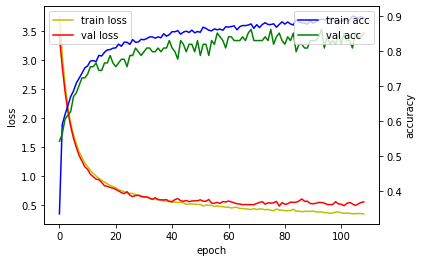

In [ ]:
acc_loss_plot(hist_e)

In [ ]:
predict_e1 = e_model1.predict(test_x)


## 답안지 제출

In [ ]:
sample_sub.iloc[:, 1:] = predict_e1
sample_sub

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0.000337,0.000010,5.914159e-06,0.000013,2.285845e-04,0.000003,2.701673e-05,0.000011,0.000158,0.000279,0.198388,2.615649e-01,1.726362e-04,5.160241e-01,0.008212,0.000094,9.585202e-06,7.474885e-06,9.886216e-06,7.873774e-06,4.623400e-05,0.000016,0.000008,0.000721,0.006240,0.000015,0.000262,7.895535e-06,0.000024,0.000011,0.000050,1.827336e-04,0.000169,0.000007,0.000008,0.000005,0.000998,3.185869e-05,5.270202e-05,3.206364e-05,0.000009,3.666138e-06,1.354613e-03,6.034704e-05,5.476925e-05,4.039178e-05,3.026838e-05,0.000013,0.000082,0.000139,0.000004,9.783831e-04,1.205096e-04,1.552485e-05,0.000013,4.818855e-06,7.708135e-06,0.000005,2.435531e-03,1.261856e-05,0.000167
1,3126,0.000190,0.000017,6.992853e-07,0.000141,3.343965e-06,0.000078,2.336036e-06,0.000050,0.000005,0.000003,0.000005,1.726672e-06,1.214419e-06,5.798091e-07,0.000004,0.000099,2.626934e-06,3.306961e-06,1.468614e-06,7.071531e-07,1.161129e-06,0.000026,0.000170,0.000077,0.000009,0.000005,0.997782,5.955113e-06,0.000006,0.000005,0.000006,1.486884e-06,0.000289,0.000028,0.000008,0.000085,0.000012,2.452304e-06,5.486767e-06,5.449000e-07,0.000091,8.108706e-06,2.587932e-06,2.223350e-06,2.657715e-06,1.831231e-06,6.730048e-07,0.000026,0.000127,0.000446,0.000055,2.963222e-06,1.530002e-06,2.917954e-06,0.000019,3.280876e-06,2.718871e-06,0.000024,7.374572e-07,1.480734e-06,0.000043
2,3127,0.000055,0.042654,3.184656e-05,0.000014,2.284600e-05,0.000058,8.682142e-03,0.000550,0.002537,0.000034,0.000064,1.058849e-04,1.519535e-04,7.660736e-05,0.000667,0.000267,1.738270e-04,1.091773e-04,1.787074e-05,2.852715e-05,3.136386e-05,0.000025,0.000019,0.000043,0.000030,0.000067,0.002475,1.523146e-04,0.000408,0.002302,0.000017,2.597667e-05,0.000842,0.000360,0.000478,0.000030,0.000575,3.600525e-02,4.680358e-04,3.030015e-04,0.000364,4.013293e-05,7.912696e-04,6.411739e-03,6.753890e-03,8.694878e-01,4.388572e-05,0.003140,0.007788,0.000855,0.000060,9.169408e-05,9.113552e-05,2.351369e-05,0.000687,1.788940e-05,8.912665e-05,0.000032,3.460434e-05,9.452455e-04,0.001295
3,3128,0.000151,0.000004,1.666483e-07,0.000019,8.486094e-07,0.000003,7.865438e-07,0.000007,0.000016,0.000002,0.000008,6.485120e-06,1.223522e-06,7.328720e-08,0.000001,0.000023,3.033371e-07,5.172586e-07,6.747437e-07,1.661635e-07,2.927560e-07,0.000001,0.000002,0.000007,0.000010,0.000001,0.994210,6.895606e-07,0.000009,0.000013,0.000003,4.408762e-07,0.000928,0.000003,0.000003,0.000014,0.000003,2.447087e-07,1.243839e-05,7.667146e-07,0.000003,8.049765e-07,1.956384e-07,4.760703e-07,6.334926e-07,5.428904e-07,4.558483e-07,0.000006,0.000452,0.003651,0.000045,2.889522e-06,2.586929e-06,4.272597e-07,0.000004,2.708968e-07,1.629908e-07,0.000006,3.204105e-07,1.662420e-07,0.000353
4,3129,0.000190,0.000004,4.127425e-07,0.000034,5.164472e-06,0.000007,9.360276e-07,0.000005,0.000011,0.000004,0.000004,2.307359e-06,9.276094e-07,1.413783e-07,0.000001,0.000032,7.006873e-07,2.061521e-06,2.084686e-06,4.774578e-07,3.816826e-07,0.000002,0.000009,0.000006,0.000006,0.000005,0.997167,8.015817e-07,0.000005,0.000007,0.000004,9.685109e-07,0.000577,0.000007,0.000017,0.000017,0.000003,3.847969e-07,4.570119e-06,8.516502e-07,0.000004,2.251383e-06,4.047007e-07,6.014826e-07,5.542068e-07,5.660502e-07,9.674511e-07,0.000006,0.000230,0.001348,0.000084,1.854769e-06,1.537329e-06,8.389952e-07,0.000002,4.534560e-07,4.137092e-07,0.000042,5.085009e-07,4.064796e-07,0.000124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0.000117,0.000004,4.792412e-07,0.000038,9.556001e-06,0.000007,6.420434e-07,0.000004,0.000006,0.000002,0.000002,1.311153e-06,7.321235e-07,1.455690e-07,0.000001,0.000034,1.744308e-06,3.555396e-06,2.316302

In [ ]:
sample_sub.to_csv('/content/drive/MyDrive/ML/dacon/exercise_action/submission/0222_submission_e2.csv', index = False)